## Simulation-based inference for the Azores event

Here we provide usage examples of the `seismo-sbi` package. We utilise the real event data as well as real noise examples to build a realistic empirical model of the likelihood function. This notebook has two sections:

 - First, we run a fixed location moment tensor inversion of the Azores event, and compare the SBI results with a Gaussian likelihood solution.
 - Second, we run the full 10-parameter joint moment tensor and centroid source time-location inversion using SBI.

_Note: these results differ substantially from the paper since only local permanent land stations are used for the inversions_

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import numpy as np

from seismo_sbi.sbi.configuration import SBI_Configuration
from seismo_sbi.sbi.pipeline import SingleEventPipeline, SBIPipelinePlotter

### Preparation for inversions

Make sure you have run the `download.py` and `generate_noise_database.py` scripts before running this notebook.

These scripts download data from the nearby Azores permanent land stations and produce a noise database. 

We present the full set of prerequisite configuration parameters in the cells below.

In [16]:
config = SBI_Configuration()

# specifying output filepaths, etc. 

main_config_options = dict(
    run_name='azores_real_event',
    output_directory= '.',
    job_name='fixed_location_inversion',
    generate_dataset= True,
    num_jobs= 20 # number of cores to utilise for all tasks
)

config.parse_main_options(main_config_options)

sbi_pipeline = SingleEventPipeline(config.pipeline_parameters)

### Section 1: Fixed Location Source Inversion of the Azores Event

This section performs a fixed location event inversion for the Azores event, identified by the GCMT catalogue code 202201130646A. The notebook explains the configuration setup required to run inversion with this package.

We run two simple inversions, one using SBI and the other with the Gaussian likelihood approach. We compare the resulting posterior distributions for this event.

In [17]:
# forward modelling and processing options

simulation_config_options = dict(
    components= 'ZEN',
    stations_path= '../scripts/configs/azores/azores_stations.txt',
    station_components_path= '../scripts/configs/azores/azores_components.json',
    seismogram_duration= 900,
    sampling_rate= 1,
    syngine_address= "/data/shared/ROSA_PREM_10s_disc", # if no local version, can use "syngine://prem_i_2s"
    processing=dict(
        filter=dict(
            type= 'bandpass',
            freqmin= 0.02,
            freqmax= 0.04,
            corners= 4,
            zerophase= False),
    )
)

# initial parameters configurations

seismic_source_config=dict(
  inference=dict(
    moment_tensor=dict(
      #         [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]
      fiducial= [1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15],
      stencil_deltas= [1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10],
      bounds= [[-5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16],
              [5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16]]
        ),
    ),
  nuisance=dict( # we fix the source location here
    source_location=dict(
      #         [lat, long, depth, time]
      fiducial= [39.9267,  -29.9392 , 8, 0],
      bounds= [39.9267,  -29.9392 , 8, 0]
        )
    )
)

# dataset generation parameters

dataset_config_options = dict(
    num_simulations= 1000,
    sampling_method= dict(
        moment_tensor= 'uniform',
        source_location='constant'),
   use_fisher_to_constrain_bounds = 15,
)

config.parse_seismic_context(simulation_config_options)
config.parse_parameters(seismic_source_config)
config.parse_simulations_options(dataset_config_options)

sbi_pipeline.load_seismo_parameters(config.sim_parameters, config.model_parameters, config.dataset_parameters)

In [18]:
job_data_configuration = dict(  
    real_events=dict( # specify path to the real event data
        real_north= '../scripts/data/events/azores_event_event_filtered_1hz.h5'
    ),
    simulations=dict( # we don't run any artificial events here
        random_events= 0,
        fixed_events= [],
        custom_events= {},
    ),
    noise_models=dict(
        real_noise= '../scripts/data/noise/azores_event_samples'
    ),
    plots=dict(
        async_plotting= True,
        test_posteriors= dict(
            chain_consumer= 
                [[['optimal_score', 'real_noise'], ['gaussian_likelihood', 'real_noise']]]
        ),
        disable_plotting= False
    )
)

config.parse_jobs_config(job_data_configuration)

In [19]:
# test_jobs_paths = sbi_pipeline.simulate_test_jobs(config.dataset_parameters, config.test_job_simulations)
sbi_pipeline.compute_data_vector_properties([], config.real_event_jobs)

In [20]:
compression_config = {'optimal_score':
    {'empirical_block':  '../scripts/data/noise/azores_event_samples'}
}
config.parse_compression_options(compression_config)

score_compression_data, _ = sbi_pipeline.compute_required_compression_data(
    config.compression_methods,
    config.model_parameters,  
)

sbi_pipeline.load_compressors(config.compression_methods, score_compression_data)


Found 703 noise realisations.


In [21]:
inference_options = dict(
  sbi=dict(
    method= 'posterior',
    noise_model= dict(
      type= 'real_noise',
      noise_catalogue_path= '../scripts/data/noise/azores_event_samples',
      noise_level= 3.e-6,
    ),
  ),
  likelihood= dict(
    run= True,
    ensemble= False,
    covariance= 'empirical',
    num_samples= 20000,
    walker_burn_in= 2000,
    move_size= 0.0005,
  ),
)
config.parse_sbi_config(inference_options)

sbi_pipeline.load_test_noises(config.sbi_noise_model, config.test_noise_models)

Found 703 noise realisations.
Found 703 noise realisations.


In [22]:
# now load the relevant event
job_data = sbi_pipeline.create_job_data([], config.real_event_jobs)

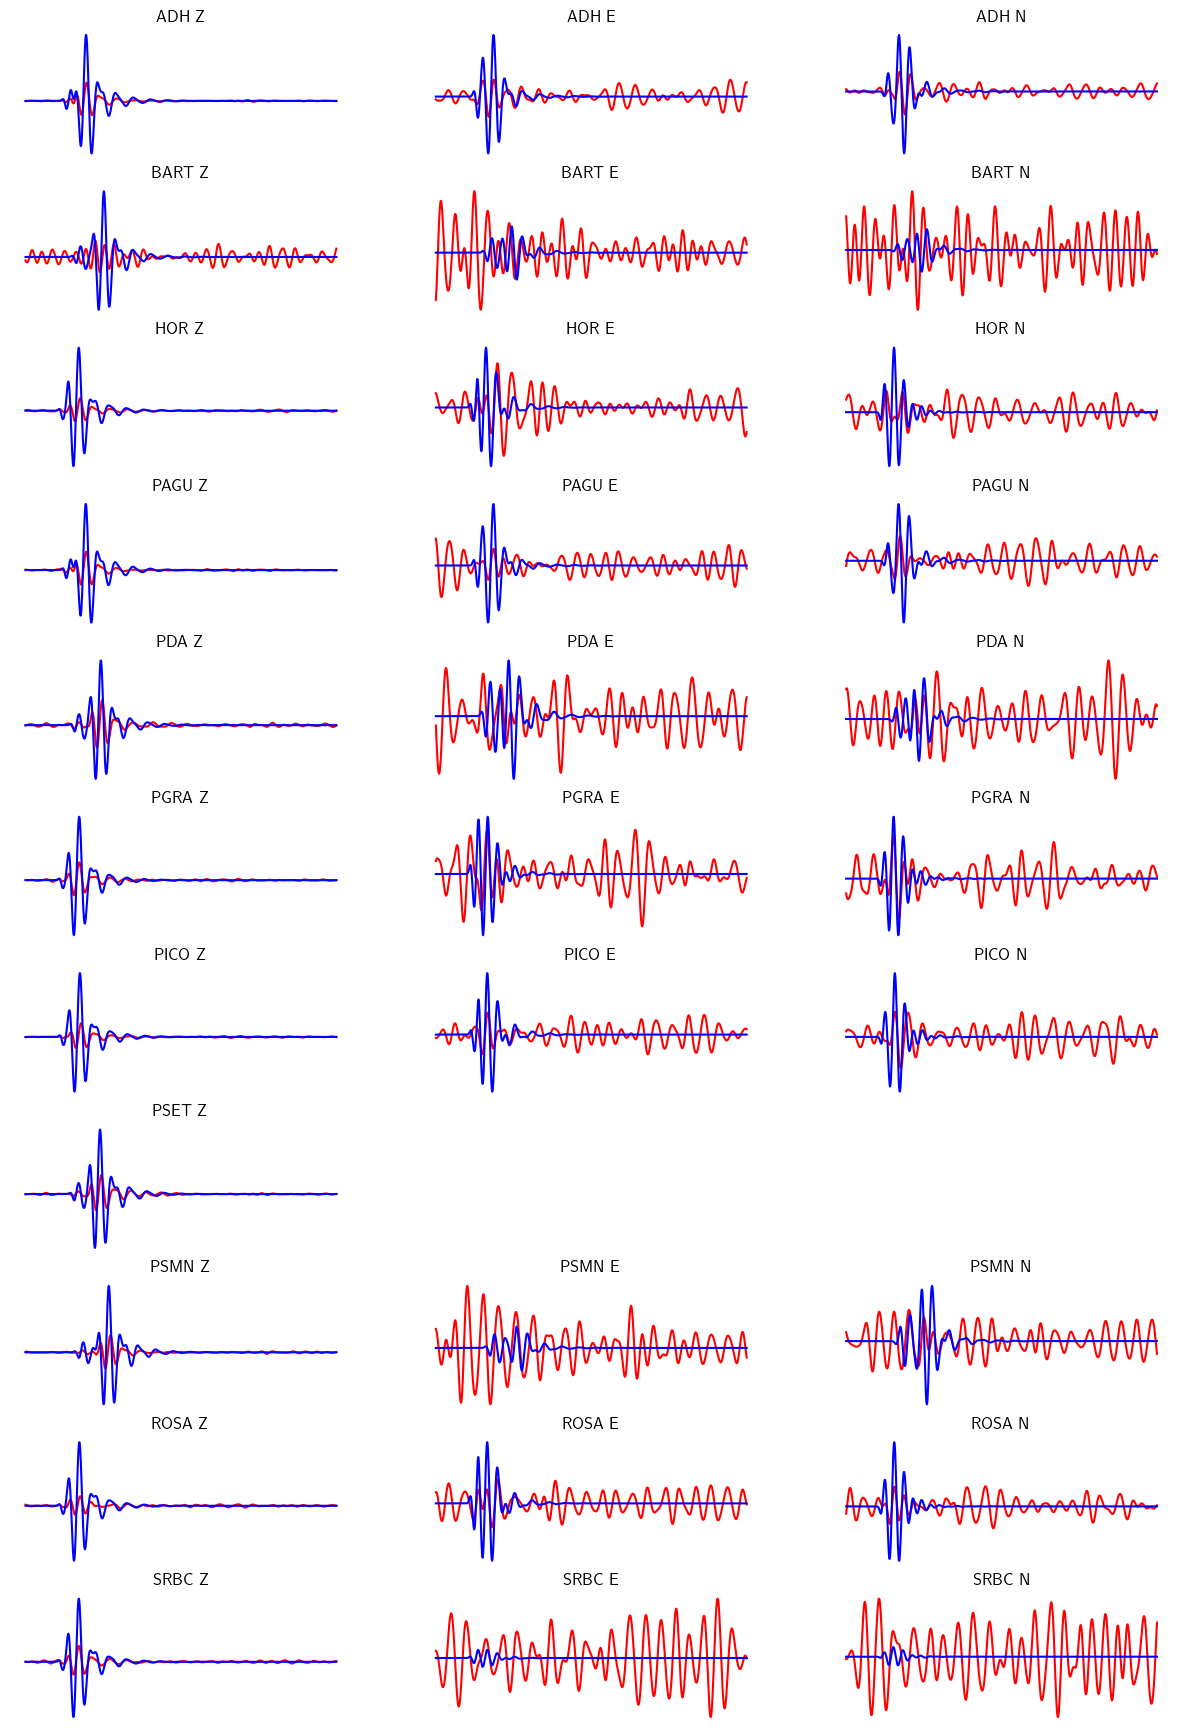

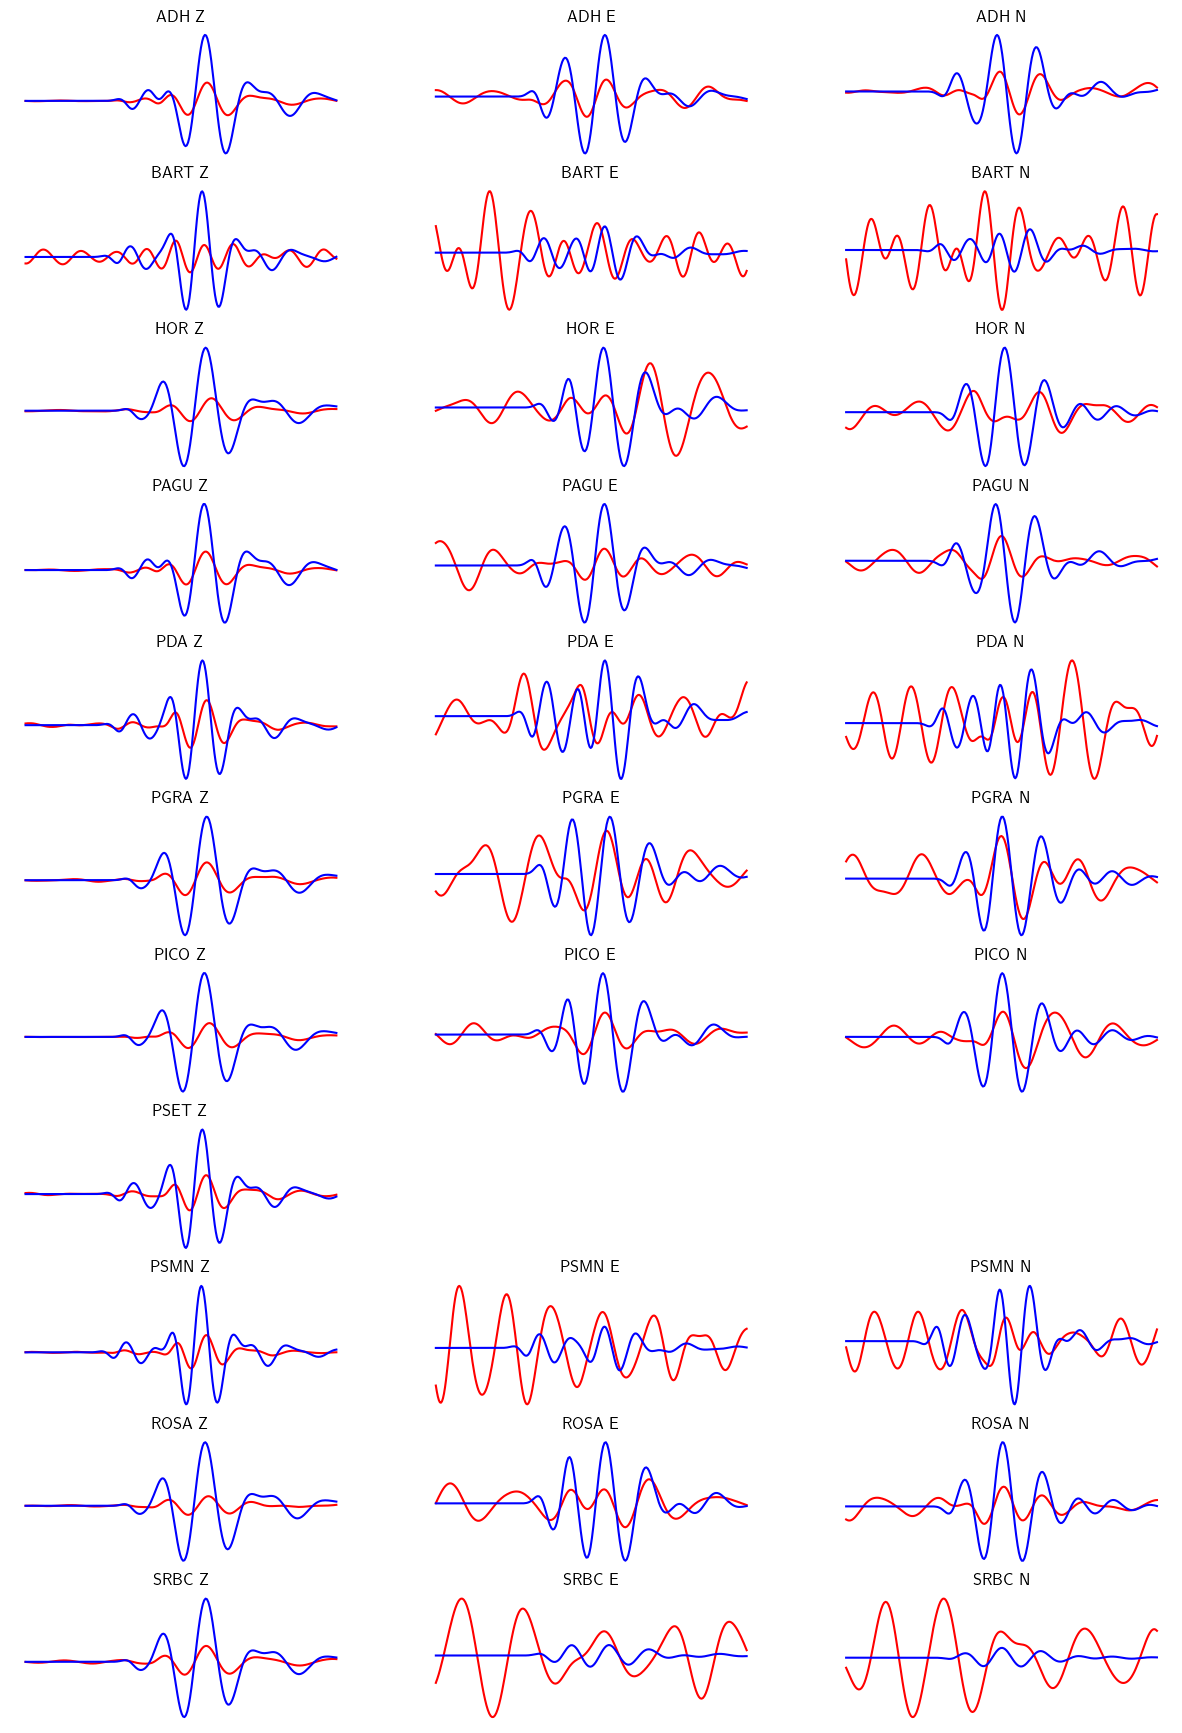

In [57]:
# let's plot the event + the GCMT solutions
from seismo_sbi.sbi.results import JobData

gcmt_mt_solution  = np.array([-2.100,  0.386,  1.720,  0.829,  0.333,  0.892]) * 1.e16
gcmt_synthetics = sbi_pipeline.simulation_callable(gcmt_mt_solution)

plotter = SBIPipelinePlotter('', sbi_pipeline.parameters)
plotter.plot_synthetic_misfits(
    job_data[0], 
    sbi_pipeline.simulation_parameters.receivers, 
    gcmt_synthetics, 
    "",
    savefig=False )


In [58]:
result_generator = sbi_pipeline.run_compressions_and_inversions(
    job_data, 
    config.sbi_method,
    config.likelihood_config, 
    config.dataset_parameters
)

results = list(result_generator)

Performing iterative least squares for MLE fiducial:   0%|          | 0/1 [00:00<?, ?it/s]

chi^2:  1.1495289398330177 damping lambda:  0.0
theta_MLE:  [-1.08043339e+15 -7.27637245e+14  5.26524586e+15 -5.26461778e+15
  1.04922657e+15  2.45165464e+15]


Performing iterative least squares for MLE fiducial: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


x0 [-1.08043339e+15 -7.27637245e+14  5.26524586e+15 -5.26461778e+15
  1.04922657e+15  2.45165464e+15]
bounds {'moment_tensor': array([[-4.83598705e+15, -4.30730292e+15,  3.02286425e+15,
        -8.65065245e+15, -1.43113610e+15, -2.86871441e+14],
       [ 2.67512027e+15,  2.85202843e+15,  7.50762747e+15,
        -1.87858312e+15,  3.52958924e+15,  5.19018072e+15]]), 'source_location': [39.9267, -29.9392, 8, 0]}


Compressing dataset: 100%|██████████| 1000/1000 [00:11<00:00, 90.48it/s]


 Neural network successfully converged after 137 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Time taken for real_north with optimal_score: 159.27450323104858s
Starting likelihood inversions.


Running MCMC chains: 100%|██████████| 20/20 [02:53<00:00,  8.67s/it]

Time taken for likelihood inversions: 173.59646201133728s


Quick sanity check: what does our best fitting solution look like compared to the observations?

In [ ]:


our_solution_MLE = results[0][1].inversion_data.compression_data.data_fiducial

plotter = SBIPipelinePlotter('', sbi_pipeline.parameters)
plotter.plot_synthetic_misfits(
    job_data[0], 
    sbi_pipeline.simulation_parameters.receivers, 
    our_solution_MLE, 
    "",
    savefig=False )


### Posterior Solutions

Finally, we can plot the resulting sample ensembles from the SBI approach (blue) vs. the Gaussian likelihood approach. 

Plotting posterior comparisons:   0%|          | 0/1 [00:00<?, ?it/s]

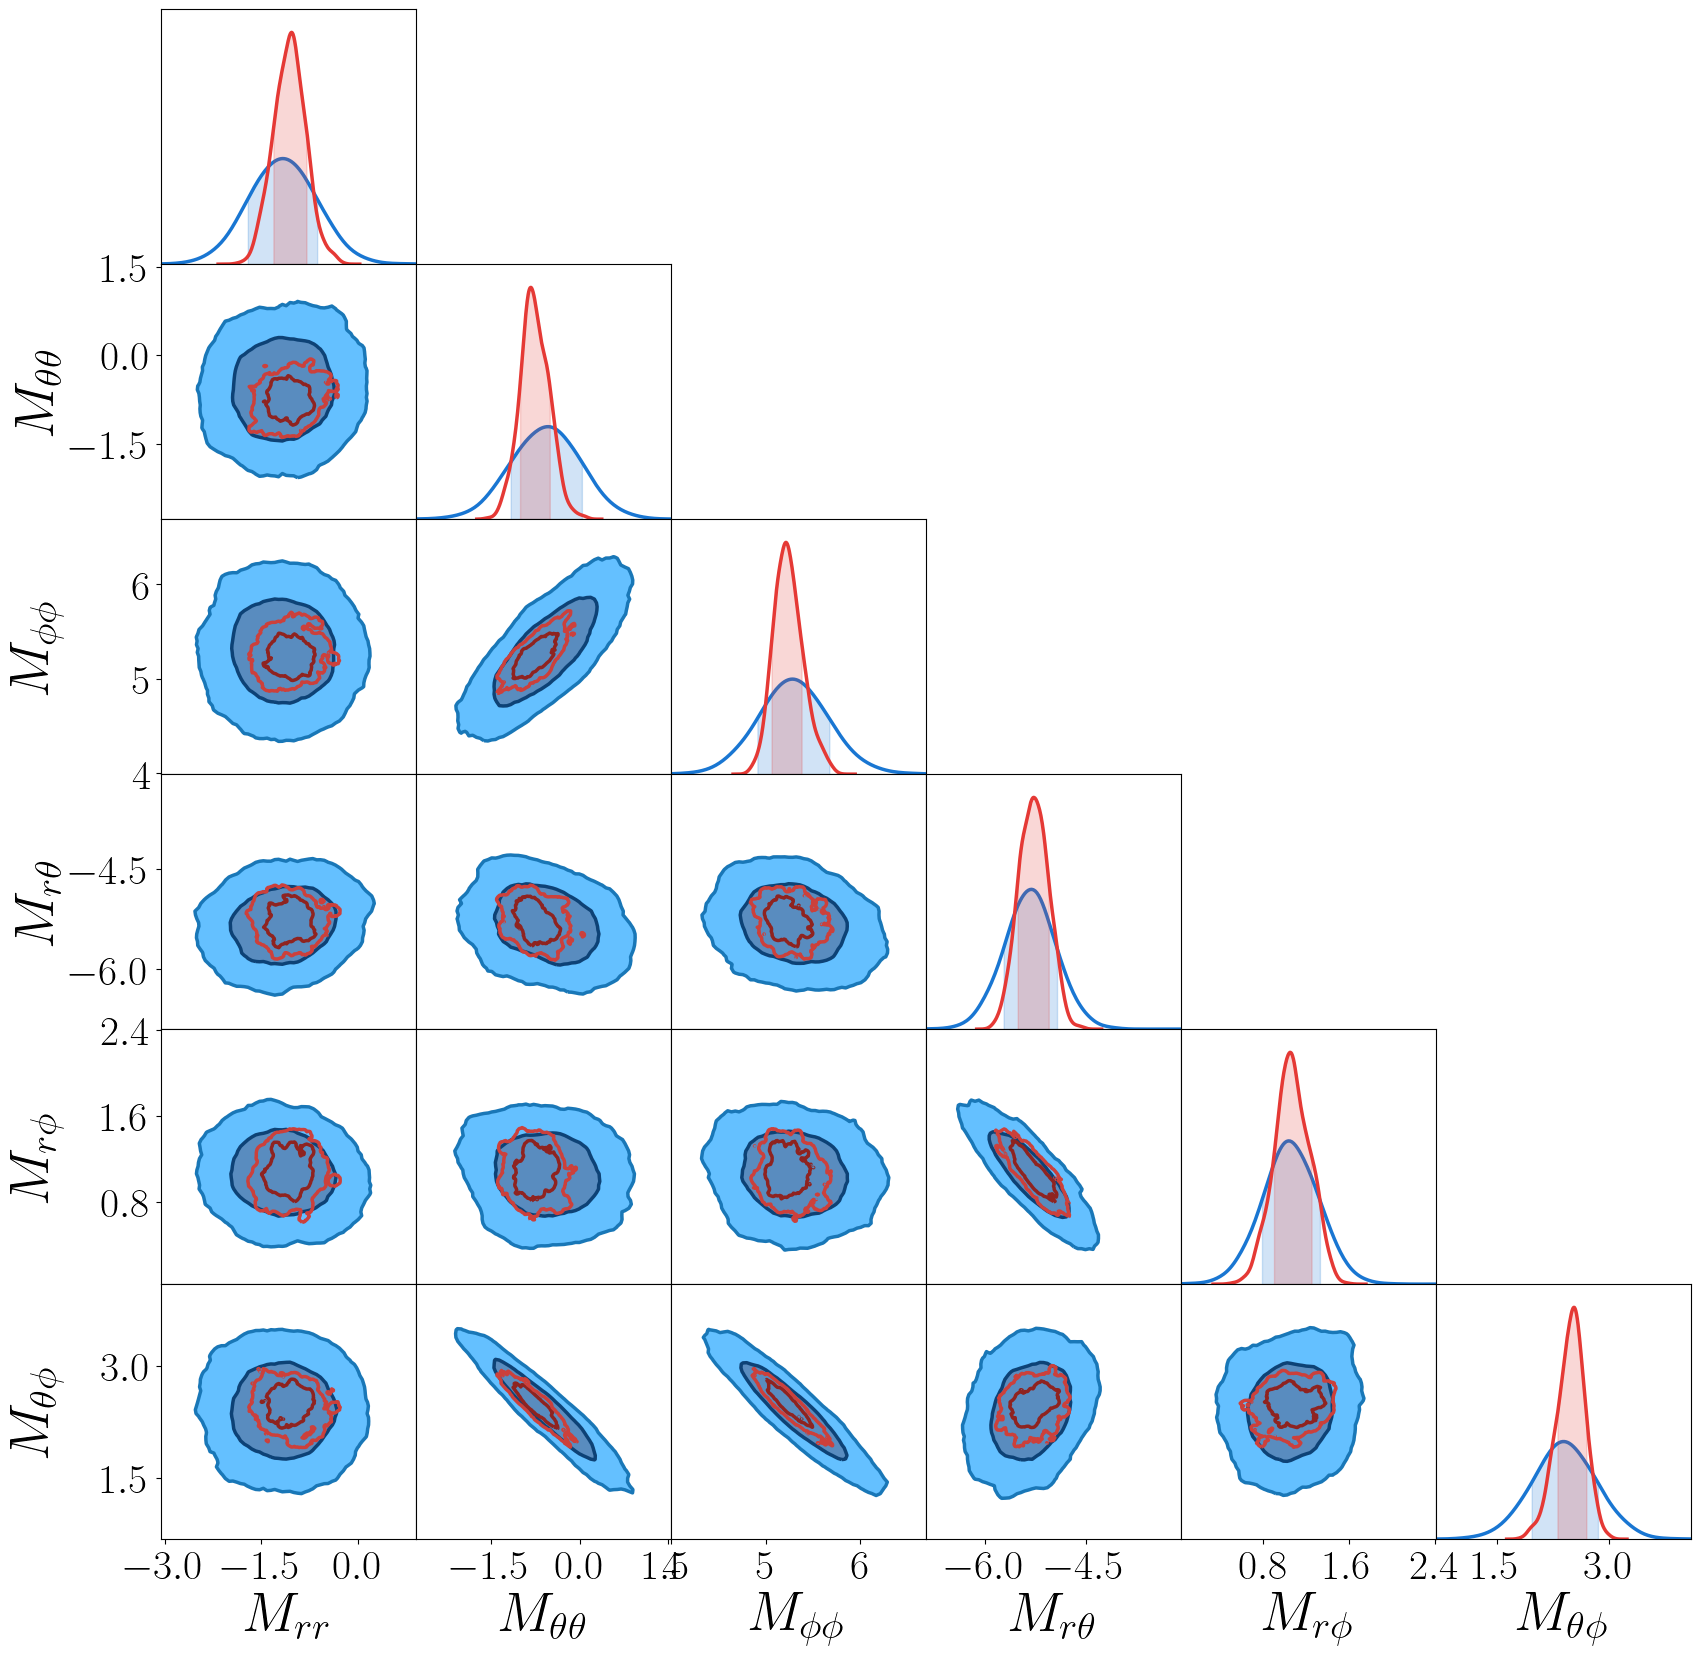

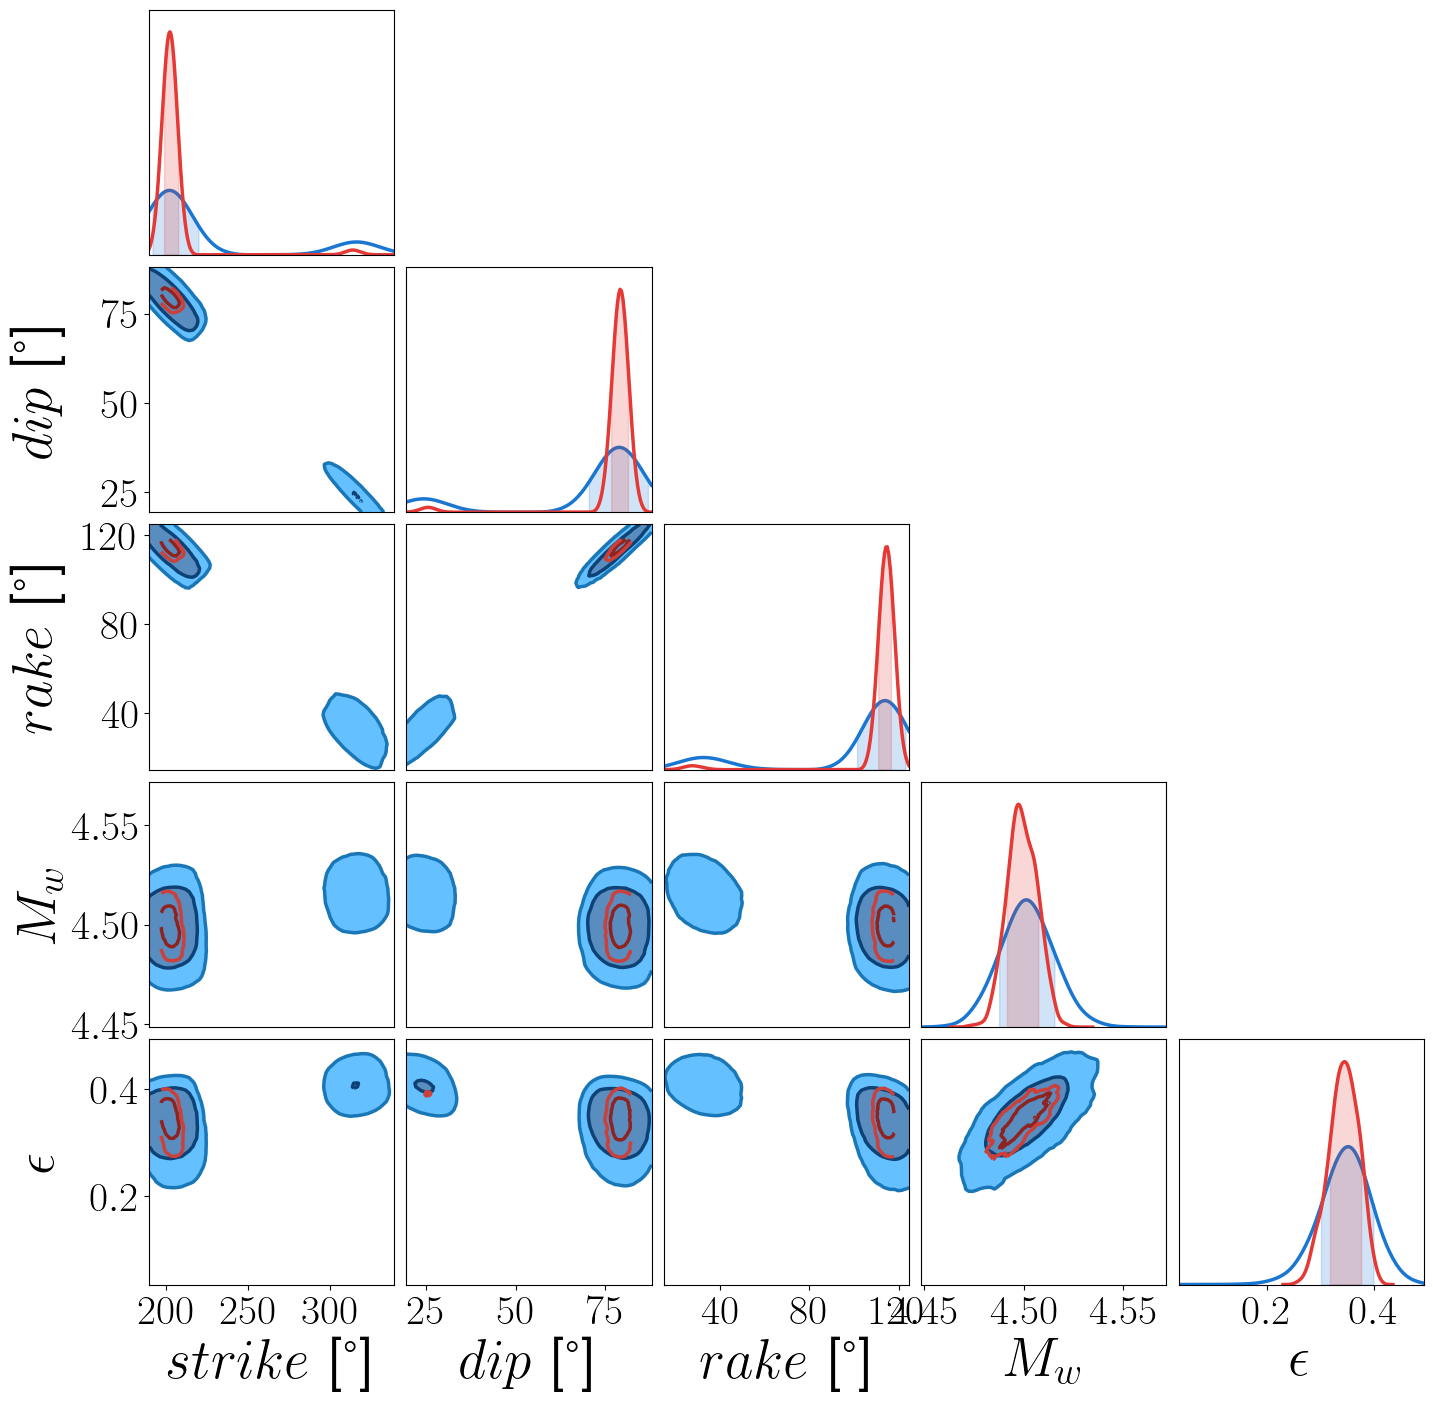

Plotting posterior comparisons: 100%|██████████| 1/1 [00:41<00:00, 41.60s/it]


In [59]:
inversion_results = [r[1] for r in results]
sbi_pipeline.plot_comparisons(inversion_results, config.plotting_options['test_posteriors']['chain_consumer'], savefig=False)

### Section 2: Full source inversion with SBI

In [31]:
main_config_options = dict(
    run_name='azores_real_event',
    output_directory= '.',
    job_name='full_inversion',
    generate_dataset= True,
    num_jobs= 20 # number of cores to utilise for all tasks
)

config = SBI_Configuration()
config.parse_main_options(main_config_options)

sbi_pipeline = SingleEventPipeline(config.pipeline_parameters)


seismic_source_config=dict(
  inference=dict(
    moment_tensor=dict(
      #         [Mrr, Mtt, Mpp, Mrt, Mrp, Mtp]
      fiducial= [1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15],
      stencil_deltas= [1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10, 1.e+10],
      bounds= [[-5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16, -5.e+16],
              [5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16, 5.e+16]]
        ),
    source_location=dict(
      #         [lat, long, depth, time]
      fiducial= [39.9267,  -29.9392 , 8, 0],
      stencil_deltas=[0.00001, 0.00001, 0.001, 0.001],
      bounds= [[39.9267, -29.9392, 8.5, -1],
              [39.9267, -29.9392, 24.5, 1]]
        )
    ),
  nuisance=dict()
)

# dataset generation parameters

dataset_config_options = dict(
    num_simulations= 2000,
    sampling_method= dict(
        moment_tensor= 'uniform',
        source_location='uniform'),
   use_fisher_to_constrain_bounds = 6,
)

config.parse_sbi_config(inference_options)
config.parse_seismic_context(simulation_config_options)
config.parse_compression_options(compression_config)
config.parse_parameters(seismic_source_config)
config.parse_simulations_options(dataset_config_options)
config.parse_jobs_config(job_data_configuration)

sbi_pipeline.load_seismo_parameters(config.sim_parameters, config.model_parameters, config.dataset_parameters)

In [24]:
score_compression_data, _ = sbi_pipeline.compute_required_compression_data(
    config.compression_methods,
    config.model_parameters,  
)

sbi_pipeline.load_compressors(config.compression_methods, score_compression_data)


Found 703 noise realisations.


In [25]:
inference_options = dict(
  sbi=dict(
    method= 'posterior',
    noise_model= dict(
      type= 'real_noise',
      noise_catalogue_path= '../scripts/data/noise/azores_event_samples',
      noise_level= 3.e-6,
    ),
  ),
# turn off likelihood inversions - you can turn them on if you want to see the results,
# but it took ~ 30 minutes with a local instaseis model
  likelihood= dict( 
    run= False,
    ensemble= True,
    covariance= 'empirical',
    num_samples= 20000,
    walker_burn_in= 2000,
    move_size= 0.0005,
  ),
)
config.parse_sbi_config(inference_options)

sbi_pipeline.load_test_noises(config.sbi_noise_model, config.test_noise_models)

Found 703 noise realisations.


In [29]:
result_generator = sbi_pipeline.run_compressions_and_inversions(
    job_data, 
    config.sbi_method,
    config.likelihood_config, 
    config.dataset_parameters
)

results = list(result_generator)

Performing iterative least squares for MLE fiducial:   0%|          | 0/25 [00:00<?, ?it/s]

chi^2: 1.14953, damping lambda: 0.007
theta_MLE:  [-3.49580329e+15  1.91376198e+14  6.02688401e+15 -5.70294730e+14
  2.42721665e+13  1.01167764e+15  4.02423349e+01 -2.97853591e+01
  9.76843571e+00  1.00408220e+00]


Performing iterative least squares for MLE fiducial:   4%|▍         | 1/25 [00:08<03:25,  8.57s/it]

chi^2: 0.90168, damping lambda: 0.004
theta_MLE:  [-8.72669681e+15  2.78233067e+15  7.43847301e+15  3.13899123e+15
  1.10101349e+15 -1.49099629e+15  4.03697974e+01 -2.98221976e+01
  4.71460368e+00 -2.62694615e+00]


Performing iterative least squares for MLE fiducial:   8%|▊         | 2/25 [00:17<03:19,  8.70s/it]

chi^2: 0.51745, damping lambda: 0.003
theta_MLE:  [-8.09955571e+15  2.90981975e+15  8.48072655e+15  5.02084650e+15
 -2.53995120e+14 -1.65698089e+15  4.03018679e+01 -2.98674768e+01
  6.18128166e+00 -2.66873891e+00]


Performing iterative least squares for MLE fiducial:  12%|█▏        | 3/25 [00:26<03:12,  8.74s/it]

chi^2: 0.39535, damping lambda: 0.002
theta_MLE:  [-4.83950163e+15  3.48498631e+15  9.06636092e+15  5.20841106e+15
 -5.24310706e+13 -1.32086253e+15  4.03135154e+01 -2.98661361e+01
  7.33169431e+00 -2.73182655e+00]


Performing iterative least squares for MLE fiducial:  16%|█▌        | 4/25 [00:34<03:03,  8.73s/it]

chi^2: 0.38819, damping lambda: 0.001
theta_MLE:  [-5.86792157e+15  3.10014845e+15  8.62494417e+15  5.26913588e+15
 -3.95706805e+12 -1.16840425e+15  4.03192293e+01 -2.98753159e+01
  7.26359449e+00 -2.97124852e+00]


Performing iterative least squares for MLE fiducial:  20%|██        | 5/25 [00:42<02:49,  8.50s/it]

chi^2: 0.38627, damping lambda: 0.001
theta_MLE:  [-5.87106926e+15  3.11043106e+15  8.72386400e+15  5.34357958e+15
  4.06267334e+13 -1.18156806e+15  4.03265375e+01 -2.98791441e+01
  7.33808965e+00 -3.11567101e+00]


Performing iterative least squares for MLE fiducial:  24%|██▍       | 6/25 [00:50<02:35,  8.16s/it]

chi^2: 0.38627, damping lambda: 0.002
theta_MLE:  [-5.99893213e+15  3.08971458e+15  8.67655595e+15  5.35517684e+15
 -1.11040181e+13 -1.19032196e+15  4.03243356e+01 -2.98763849e+01
  7.27847353e+00 -3.05416059e+00]


Performing iterative least squares for MLE fiducial:  28%|██▊       | 7/25 [00:59<02:31,  8.40s/it]

chi^2: 0.38627, damping lambda: 0.002
theta_MLE:  [-5.93484217e+15  3.10666409e+15  8.71905098e+15  5.36076145e+15
  1.25022460e+13 -1.19350437e+15  4.03262676e+01 -2.98780269e+01
  7.31793138e+00 -3.09821570e+00]


Performing iterative least squares for MLE fiducial:  32%|███▏      | 8/25 [01:08<02:27,  8.70s/it]

chi^2: 0.38626, damping lambda: 0.002
theta_MLE:  [-5.99235405e+15  3.09462169e+15  8.69296342e+15  5.36661831e+15
 -1.31582171e+12 -1.19545957e+15  4.03253581e+01 -2.98771139e+01
  7.28901768e+00 -3.07619895e+00]


Performing iterative least squares for MLE fiducial:  36%|███▌      | 9/25 [01:17<02:18,  8.67s/it]

chi^2: 0.38626, damping lambda: 0.002
theta_MLE:  [-5.95909866e+15  3.10260860e+15  8.71033275e+15  5.36344697e+15
  5.19503459e+12 -1.19540240e+15  4.03259255e+01 -2.98776029e+01
  7.30680238e+00 -3.08885755e+00]


Performing iterative least squares for MLE fiducial:  40%|████      | 10/25 [01:26<02:13,  8.91s/it]

chi^2: 0.38626, damping lambda: 0.002
theta_MLE:  [-5.97997589e+15  3.09799179e+15  8.70081947e+15  5.36651176e+15
  2.04693630e+12 -1.19596872e+15  4.03256641e+01 -2.98773647e+01
  7.29644571e+00 -3.08300878e+00]


Performing iterative least squares for MLE fiducial:  44%|████▍     | 11/25 [01:35<02:04,  8.87s/it]

chi^2: 0.38626, damping lambda: 0.003
theta_MLE:  [-5.96998053e+15  3.10030182e+15  8.70568121e+15  5.36526077e+15
  3.50168764e+12 -1.19586989e+15  4.03257998e+01 -2.98774798e+01
  7.30152058e+00 -3.08592158e+00]


Performing iterative least squares for MLE fiducial:  48%|████▊     | 12/25 [01:44<01:56,  8.99s/it]

chi^2: 0.38626, damping lambda: 0.003
theta_MLE:  [-5.97464558e+15  3.09930994e+15  8.70360724e+15  5.36583875e+15
  2.80244191e+12 -1.19597855e+15  4.03257441e+01 -2.98774285e+01
  7.29927396e+00 -3.08470735e+00]


Performing iterative least squares for MLE fiducial:  52%|█████▏    | 13/25 [01:52<01:44,  8.71s/it]

chi^2: 0.38626, damping lambda: 0.003
theta_MLE:  [-5.97293787e+15  3.09967035e+15  8.70440014e+15  5.36574804e+15
  3.12466338e+12 -1.19597250e+15  4.03257682e+01 -2.98774507e+01
  7.30009387e+00 -3.08522882e+00]


Performing iterative least squares for MLE fiducial:  56%|█████▌    | 14/25 [02:02<01:37,  8.85s/it]

chi^2: 0.38626, damping lambda: 0.003
theta_MLE:  [-5.97354369e+15  3.09956189e+15  8.70415253e+15  5.36574759e+15
  2.98018437e+12 -1.19598205e+15  4.03257600e+01 -2.98774420e+01
  7.29982595e+00 -3.08504241e+00]


Performing iterative least squares for MLE fiducial:  60%|██████    | 15/25 [02:12<01:34,  9.44s/it]

chi^2: 0.38626, damping lambda: 0.004
theta_MLE:  [-5.97337499e+15  3.09958977e+15  8.70422370e+15  5.36577694e+15
  3.03717912e+12 -1.19598558e+15  4.03257630e+01 -2.98774452e+01
  7.29989655e+00 -3.08511023e+00]


Performing iterative least squares for MLE fiducial:  64%|██████▍   | 16/25 [02:20<01:19,  8.88s/it]

chi^2: 0.38626, damping lambda: 0.004
theta_MLE:  [-5.97342786e+15  3.09958385e+15  8.70420723e+15  5.36576436e+15
  3.01646463e+12 -1.19598606e+15  4.03257622e+01 -2.98774441e+01
  7.29987801e+00 -3.08509059e+00]


Performing iterative least squares for MLE fiducial:  68%|██████▊   | 17/25 [02:28<01:09,  8.67s/it]

chi^2: 0.38626, damping lambda: 0.005
theta_MLE:  [-5.97341575e+15  3.09958511e+15  8.70421161e+15  5.36577129e+15
  3.02294429e+12 -1.19598699e+15  4.03257624e+01 -2.98774445e+01
  7.29988177e+00 -3.08509705e+00]


Performing iterative least squares for MLE fiducial:  72%|███████▏  | 18/25 [02:37<01:00,  8.62s/it]

chi^2: 0.38626, damping lambda: 0.005
theta_MLE:  [-5.97342028e+15  3.09958489e+15  8.70421078e+15  5.36576966e+15
  3.02101562e+12 -1.19598713e+15  4.03257624e+01 -2.98774444e+01
  7.29988062e+00 -3.08509568e+00]


Performing iterative least squares for MLE fiducial:  76%|███████▌  | 19/25 [02:44<00:48,  8.14s/it]

chi^2: 0.38626, damping lambda: 0.006
theta_MLE:  [-5.97341948e+15  3.09958498e+15  8.70421112e+15  5.36577038e+15
  3.02154891e+12 -1.19598728e+15  4.03257624e+01 -2.98774444e+01
  7.29988082e+00 -3.08509620e+00]


Performing iterative least squares for MLE fiducial:  80%|████████  | 20/25 [02:51<00:39,  7.86s/it]

chi^2: 0.38626, damping lambda: 0.006
theta_MLE:  [-5.97341997e+15  3.09958496e+15  8.70421107e+15  5.36577038e+15
  3.02137290e+12 -1.19598733e+15  4.03257624e+01 -2.98774444e+01
  7.29988070e+00 -3.08509616e+00]


Performing iterative least squares for MLE fiducial:  84%|████████▍ | 21/25 [03:00<00:32,  8.15s/it]

chi^2: 0.38626, damping lambda: 0.007
theta_MLE:  [-5.97342019e+15  3.09958493e+15  8.70421105e+15  5.36577054e+15
  3.02145766e+12 -1.19598739e+15  4.03257624e+01 -2.98774444e+01
  7.29988061e+00 -3.08509623e+00]


Performing iterative least squares for MLE fiducial:  88%|████████▊ | 22/25 [03:08<00:24,  8.12s/it]

chi^2: 0.38626, damping lambda: 0.007
theta_MLE:  [-5.97342025e+15  3.09958495e+15  8.70421110e+15  5.36577051e+15
  3.02147756e+12 -1.19598743e+15  4.03257624e+01 -2.98774444e+01
  7.29988062e+00 -3.08509626e+00]


Performing iterative least squares for MLE fiducial:  92%|█████████▏| 23/25 [03:16<00:16,  8.19s/it]

chi^2: 0.38626, damping lambda: 0.008
theta_MLE:  [-5.97342033e+15  3.09958492e+15  8.70421105e+15  5.36577056e+15
  3.02148272e+12 -1.19598742e+15  4.03257624e+01 -2.98774444e+01
  7.29988057e+00 -3.08509627e+00]


Performing iterative least squares for MLE fiducial:  96%|█████████▌| 24/25 [03:25<00:08,  8.36s/it]

chi^2: 0.38626, damping lambda: 0.009
theta_MLE:  [-5.97342026e+15  3.09958495e+15  8.70421110e+15  5.36577054e+15
  3.02148892e+12 -1.19598743e+15  4.03257624e+01 -2.98774444e+01
  7.29988061e+00 -3.08509628e+00]


Performing iterative least squares for MLE fiducial: 100%|██████████| 25/25 [03:32<00:00,  8.51s/it]


x0 [-5.97342026e+15  3.09958495e+15  8.70421110e+15  5.36577054e+15
  3.02148892e+12 -1.19598743e+15  4.03257624e+01 -2.98774444e+01
  7.29988061e+00 -3.08509628e+00]
bounds {'moment_tensor': array([[-1.45954713e+16,  5.93691486e+14,  5.22307715e+15,
         9.38565343e+14, -2.74032019e+15, -2.92849137e+15],
       [ 2.64863074e+15,  5.60547841e+15,  1.21853451e+16,
         9.79297573e+15,  2.74636317e+15,  5.36516504e+14]]), 'source_location': array([[ 40.21885778, -29.98477305,   3.43585153,  -5.76855115],
       [ 40.43266704, -29.77011579,  11.16390968,  -0.40164141]])}


Compressing dataset: 100%|██████████| 2000/2000 [00:22<00:00, 90.68it/s] 


 Neural network successfully converged after 171 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Time taken for real_north with optimal_score: 528.9326345920563s


In [35]:
inversion_results = [r[1] for r in results]
inversion_data = inversion_results[0].inversion_data
plotter = SBIPipelinePlotter("", sbi_pipeline.parameters)
flattened_param_info = sbi_pipeline.parameters.parameter_to_vector('information')
plotter.initialise_posterior_plotter(inversion_data.data_scaler, flattened_param_info)

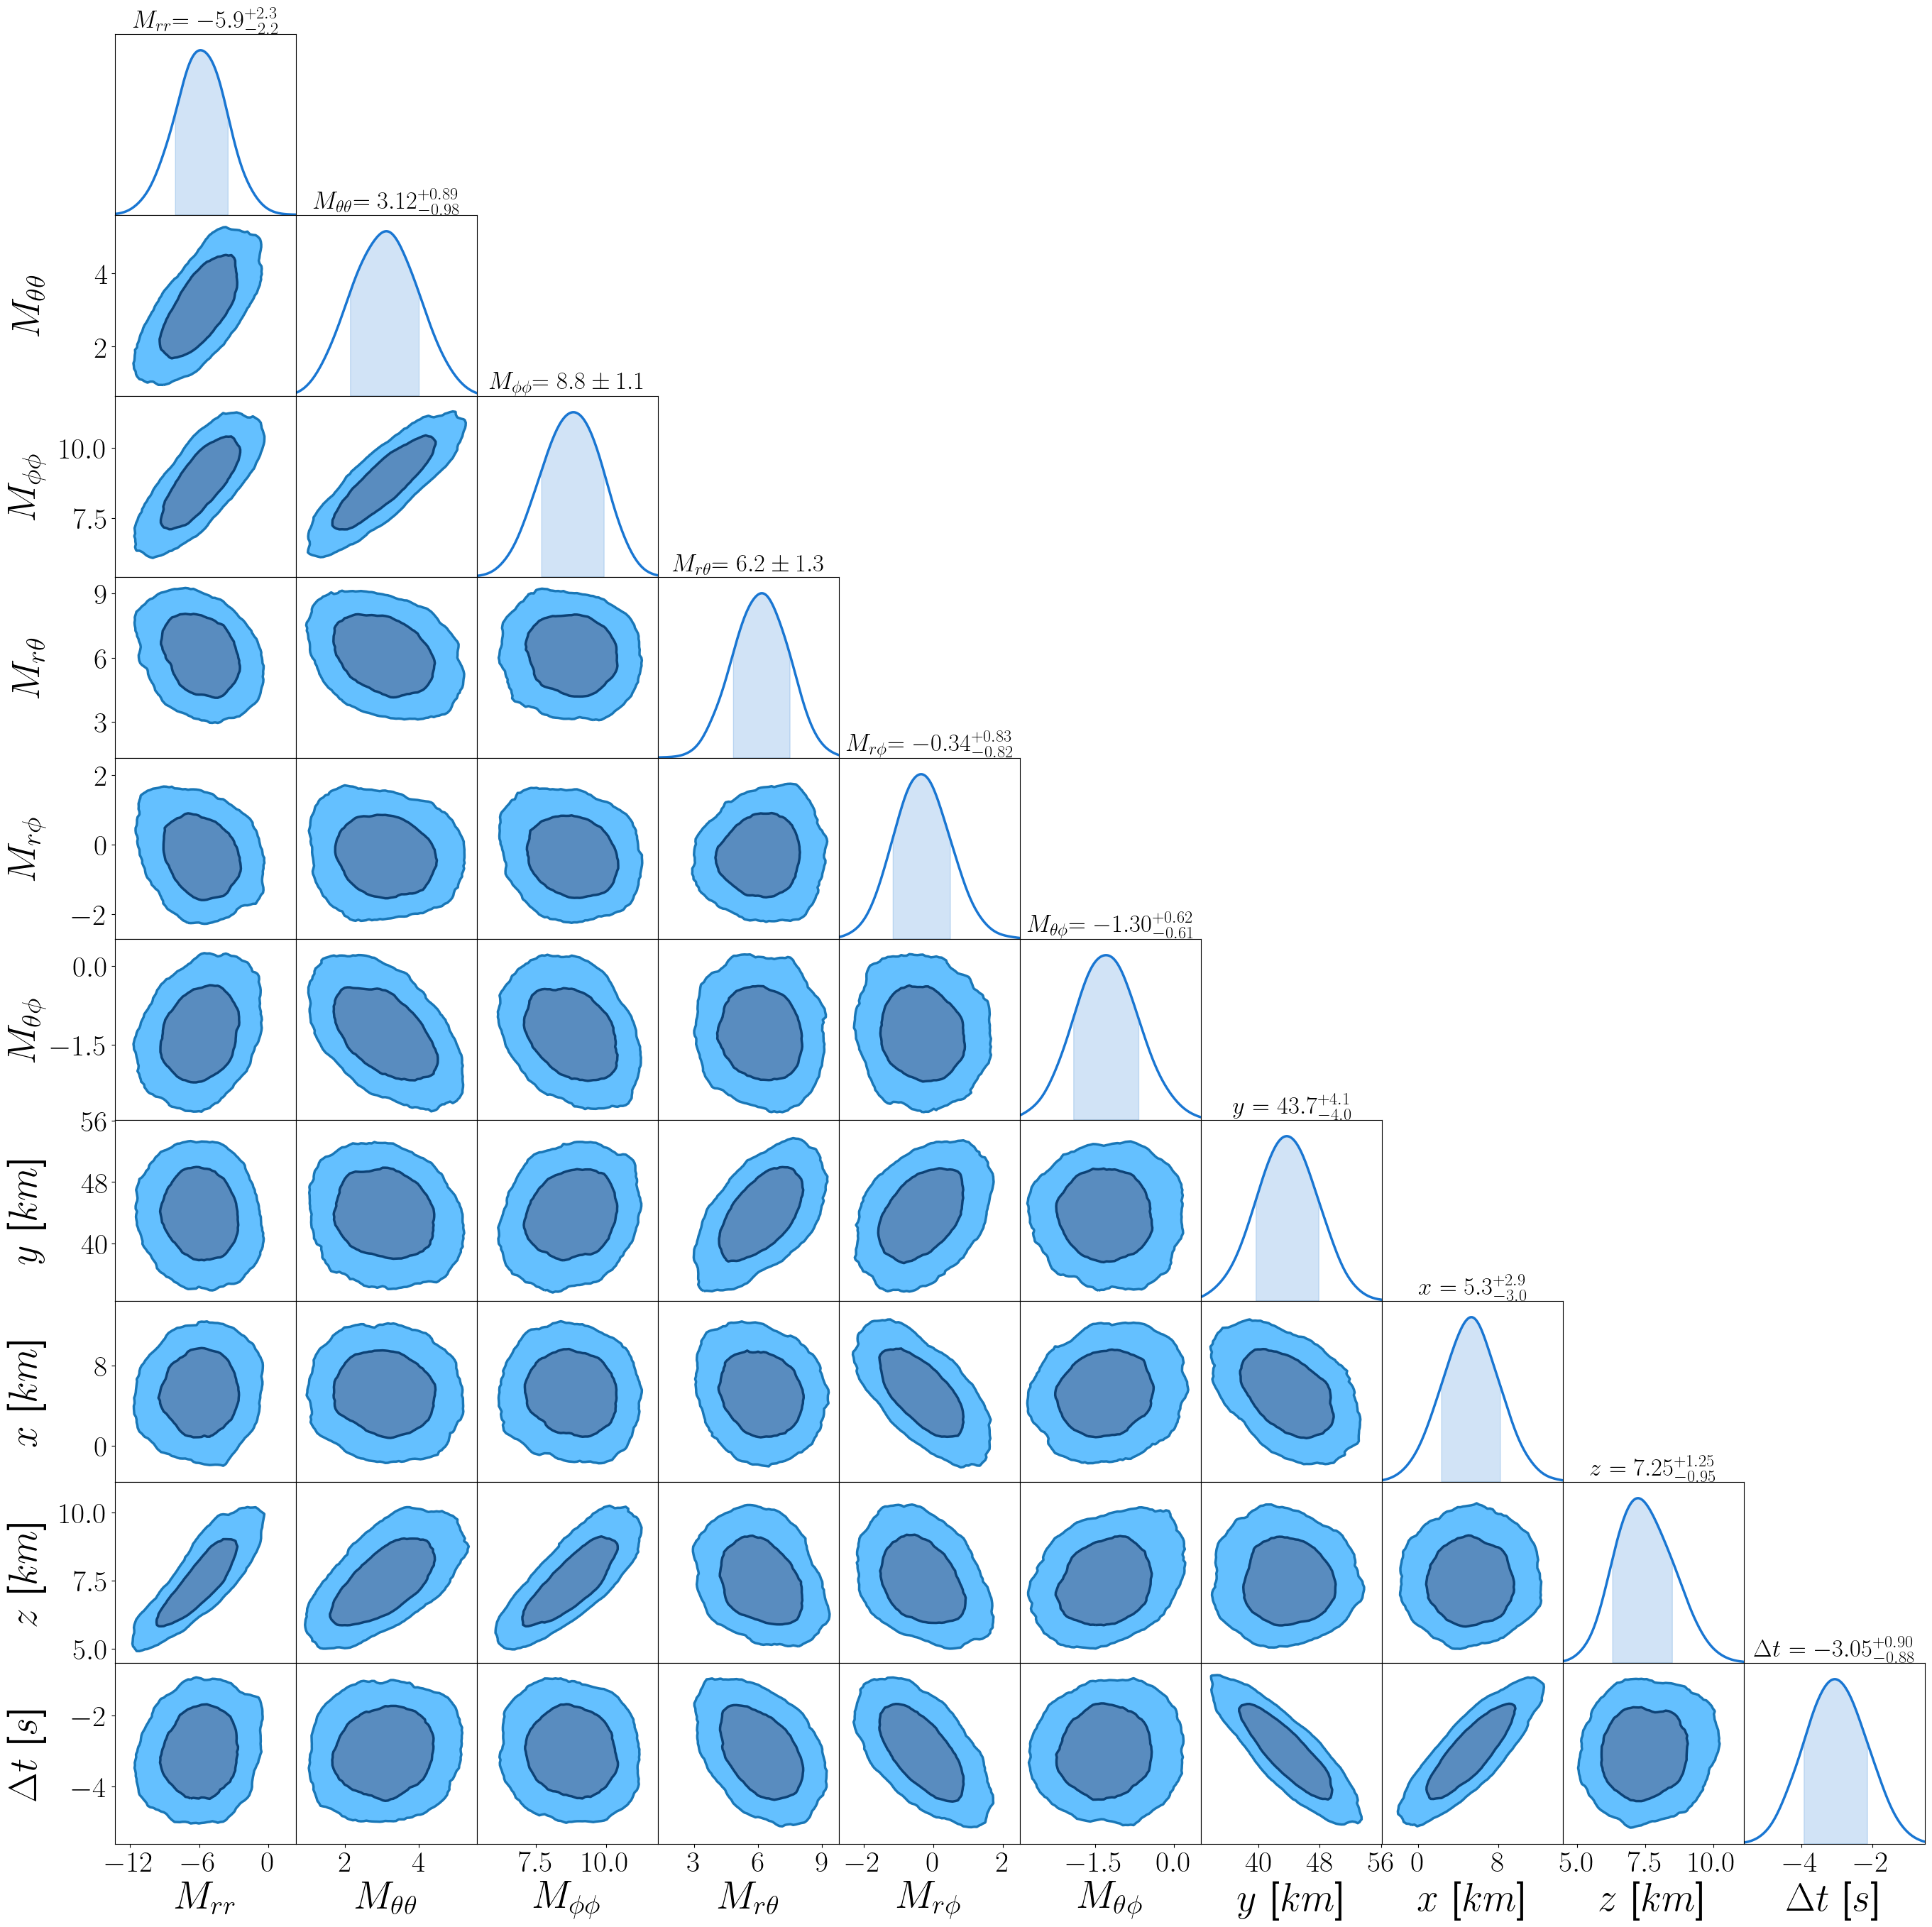

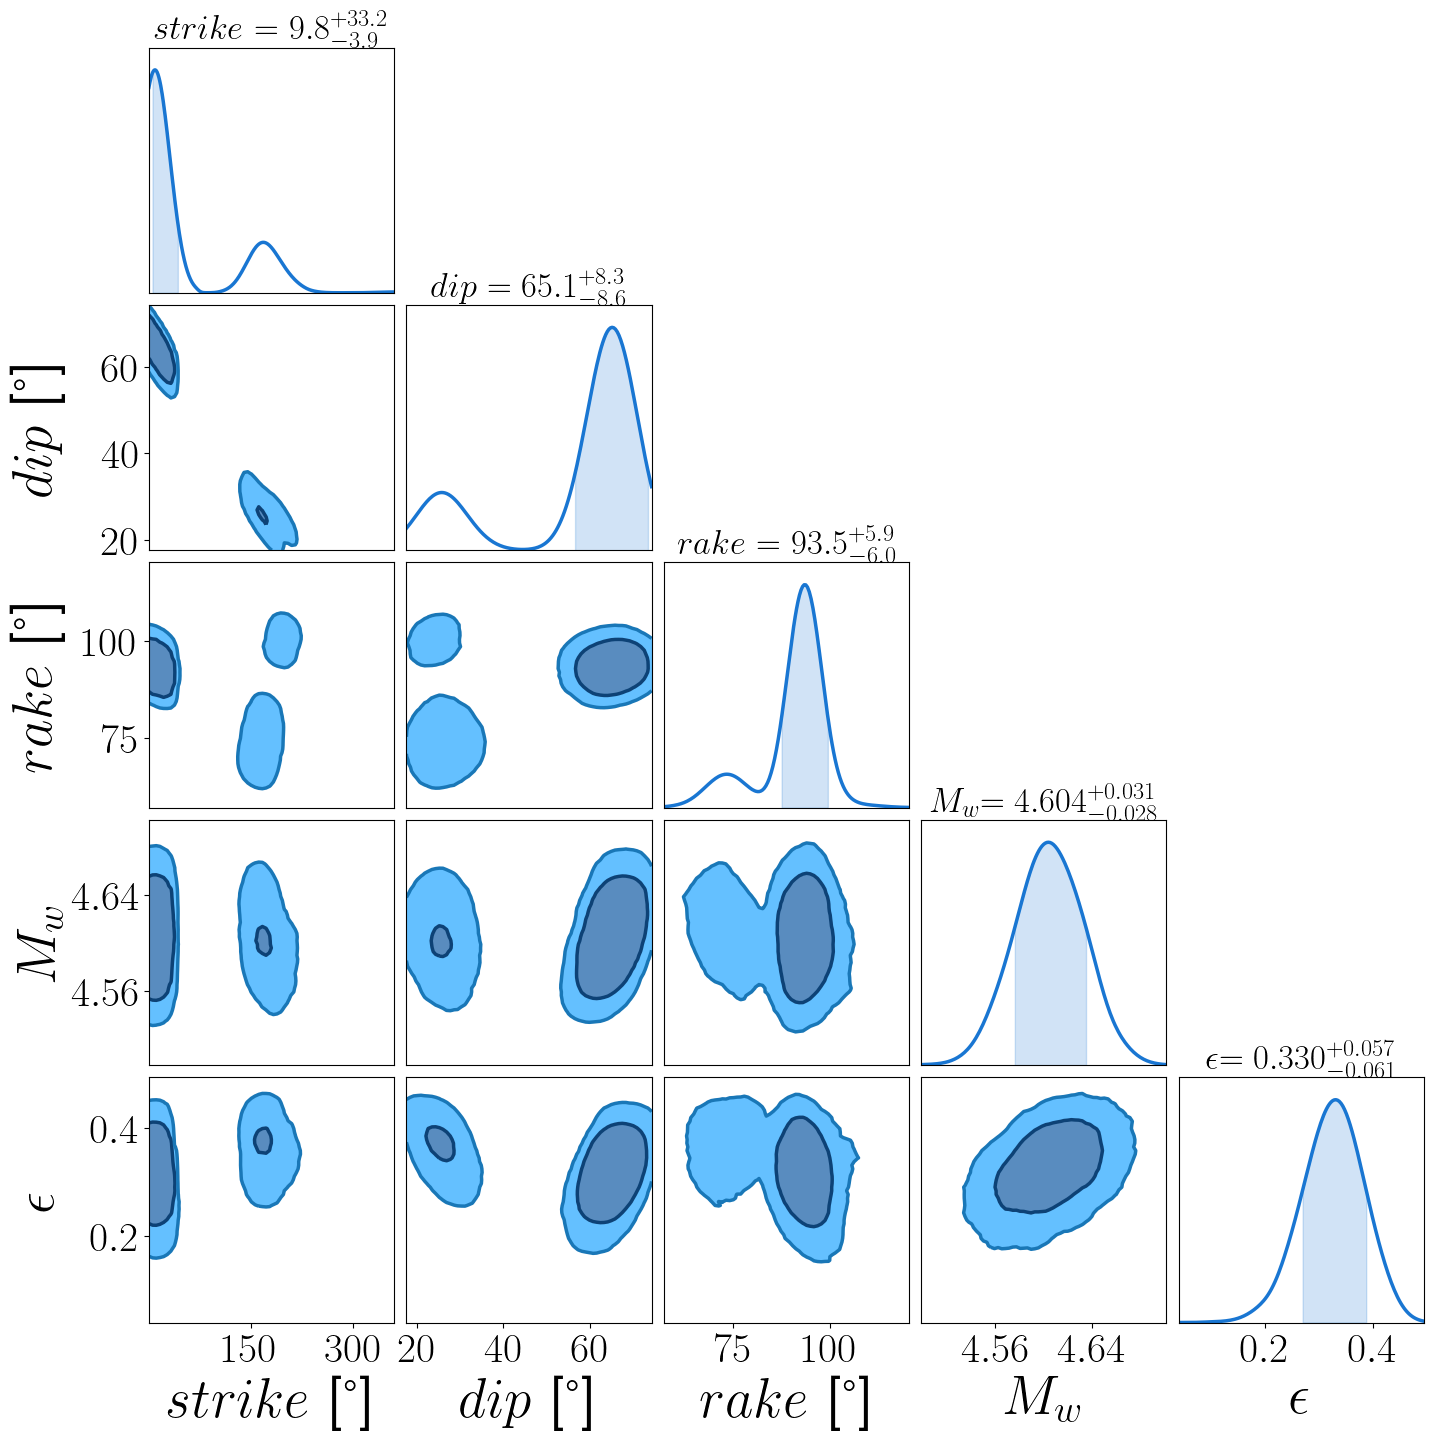

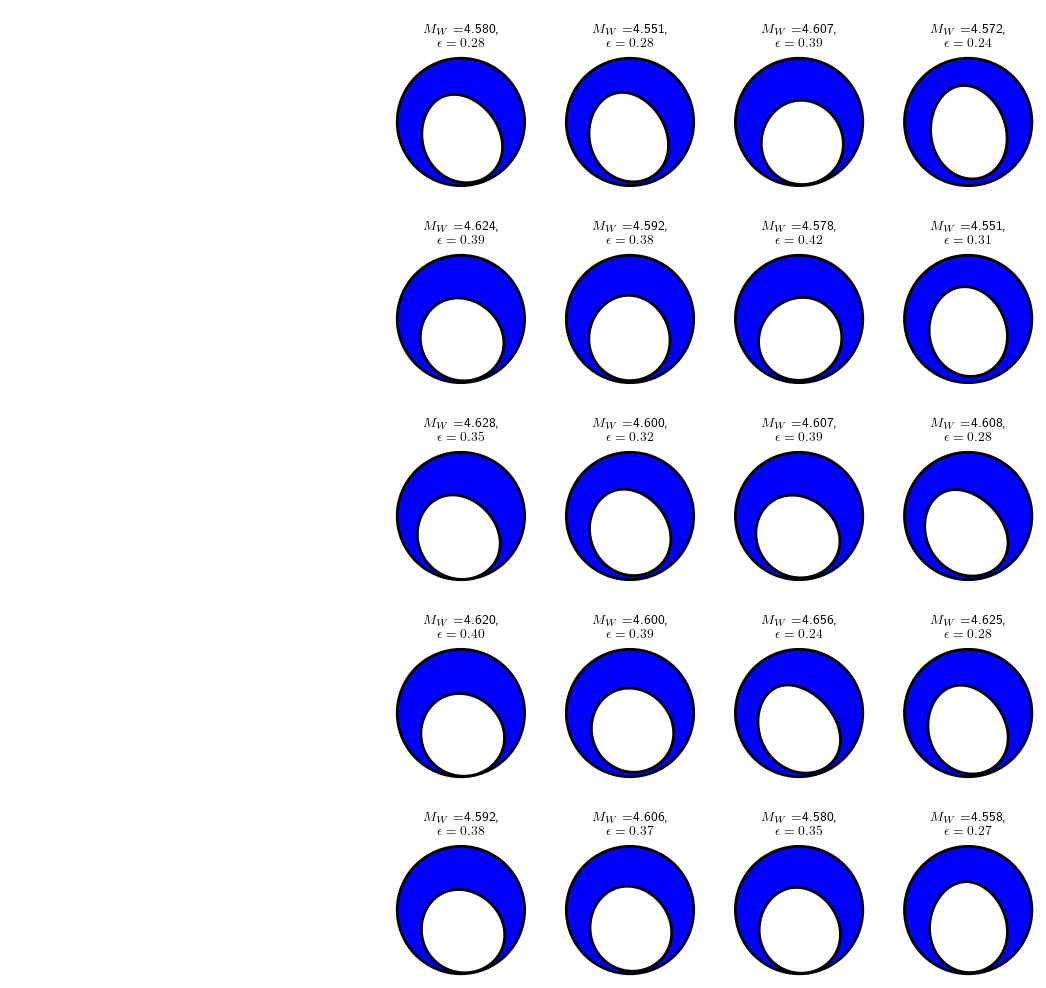

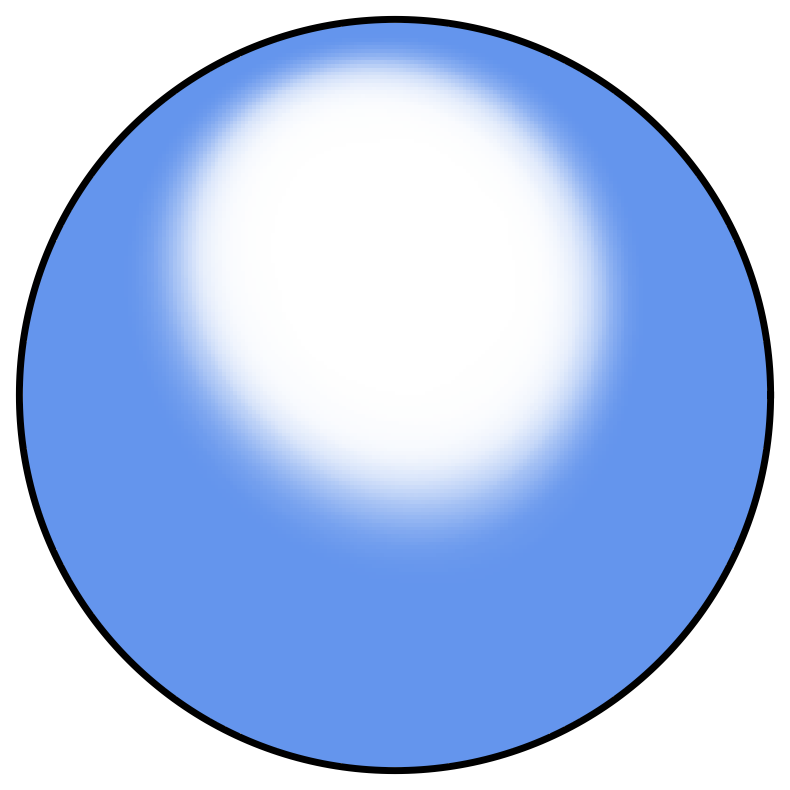

In [37]:
plotter.plot_posterior('sbi', inversion_data, kde=True, savefig=False)